# EMNIST using linear + softmax classfier
The EMNIST dataset is a set of handwritten character digits derived from the NIST Special Database 19 and converted to a 28x28 pixel image format and dataset structure that directly matches the MNIST dataset. Further information on the dataset contents and conversion process can be found in the paper available at https://arxiv.org/abs/1702.05373v1.

Dataset is available at https://www.kaggle.com/crawford/emnist

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\I342070\AppData\Local\Continuum\anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## reading
read data from csv file

In [2]:
train_data_filename = 'EMNIST_data/emnist-balanced-train.csv'
test_data_filename = 'EMNIST_data/emnist-balanced-test.csv'
raw_train_data = pd.read_csv(train_data_filename, header=None).values
raw_test_data = pd.read_csv(test_data_filename, header=None).values

read mapping file

In [3]:
mapping_filename = 'EMNIST_data/emnist-balanced-mapping.txt'
mapper = {}
with open(mapping_filename) as f:
    m = map(str.split, f.readlines())
    for item in m:
        mapper.update({int(item[0]): chr(int(item[1]))})
print(mapper)

{0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9', 10: 'A', 11: 'B', 12: 'C', 13: 'D', 14: 'E', 15: 'F', 16: 'G', 17: 'H', 18: 'I', 19: 'J', 20: 'K', 21: 'L', 22: 'M', 23: 'N', 24: 'O', 25: 'P', 26: 'Q', 27: 'R', 28: 'S', 29: 'T', 30: 'U', 31: 'V', 32: 'W', 33: 'X', 34: 'Y', 35: 'Z', 36: 'a', 37: 'b', 38: 'd', 39: 'e', 40: 'f', 41: 'g', 42: 'h', 43: 'n', 44: 'q', 45: 'r', 46: 't'}


## loading
load data into numpy

In [4]:
classes = 47
eye = np.eye(classes)
train_images, train_labels = raw_train_data[:, 1:].astype(np.float32), eye[raw_train_data[:, :1].ravel()]
test_images, test_labels = raw_test_data[:, 1:].astype(np.float32), eye[raw_test_data[:, :1].ravel()]
print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

(112800, 784)
(112800, 47)
(18800, 784)
(18800, 47)


## data visiualization

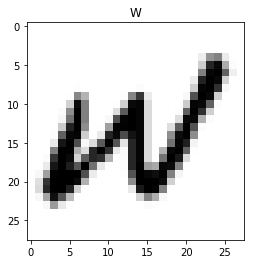

In [5]:
index = 69
img = train_images[index].reshape(28,28).T
plt.imshow(img,cmap='binary')
plt.title(mapper[np.argmax(train_labels[index])])
plt.show()

data normalization

In [6]:
train_images/=255.0
test_images/=255.0

## modeling
create a simple linear model classifier

In [26]:
def my_model(inputs, layers, units):
    parameters = {}
    for index, layer in enumerate(layers):
        parameters['l' + str(index+1)] = tf.layers.dense(inputs=inputs, units=layer, activation=tf.nn.relu)
    y = tf.layers.dense(inputs=parameters['l' + str(len(layers))], units=units)
    return y, parameters

In [33]:
x = tf.placeholder("float", [None, 784])
y, _ = my_model(x, [100, 100], classes)
y_hat = tf.nn.softmax(y)

<font color='red'>To ensure numeric stability, standard cross entropy formula should not be used.</font>

see also https://stackoverflow.com/questions/33712178/tensorflow-nan-bug

In [34]:
y_ = tf.placeholder("float", [None,classes])
# cross_entropy = -tf.reduce_sum(y_*tf.log(y))
cross_entropy = tf.reduce_sum(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y))
train_step = tf.train.AdamOptimizer().minimize(cross_entropy)

## training
using batch gradient decsent to train the model with 10000 iterations

0 146989.39393615723
1 93853.35976409912
2 79821.52637863159
3 71760.62347793579
4 66369.86445236206
5 62541.91327667236
6 59520.056577682495
7 57193.313440322876
8 55310.23824310303
9 53484.21646499634
10 52148.09350967407
11 50871.05572319031
12 49825.88235282898
13 48729.93259429932
14 47937.912424087524
15 46942.11043930054
16 46276.38357925415
17 45639.62266731262
18 44947.12981033325
19 44342.63900947571


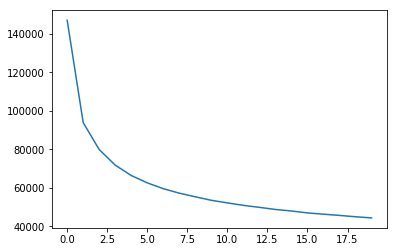

In [35]:
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()
batch_size = 100
costs = []
for epoch in range(20):
    cost = 0
    p = np.arange(train_images.shape[0])
    np.random.shuffle(p)
    batch_length = np.ceil(train_images.shape[0] / batch_size).astype(int)
    for i in range(batch_length):
        d1 = i * batch_size
        d2 = min(d1 + batch_size, train_images.shape[0])
        d = sess.run([train_step, cross_entropy], feed_dict={
            x: train_images[p[d1 : d2]], 
            y_: train_labels[p[d1 : d2]]
        })
        cost += d[1]
    print(epoch, cost)
    costs.append(cost)
plt.plot(costs)

## evaluating

In [36]:
# print('weight:', b.eval())
correct_prediction = tf.equal(tf.argmax(y_hat,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print('training set accuracy:', sess.run(accuracy, feed_dict={x: train_images, y_: train_labels}))
print('test set accuracy:', sess.run(accuracy, feed_dict={x: test_images, y_: test_labels}))

training set accuracy: 0.87192374
test set accuracy: 0.8236702


## result visiualization

Model predicts N


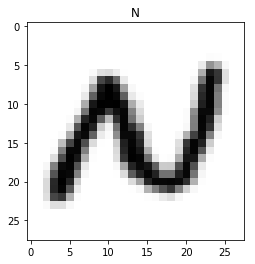

In [11]:
index = 8140
img = test_images[index].reshape(28,28).T
plt.imshow(img,cmap='binary')
plt.title(mapper[np.argmax(test_labels[index])])
prediction = tf.argmax(y, 1)
print('Model predicts', mapper[prediction.eval(feed_dict={x: test_images[index].reshape(1,784)})[0]])